In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx


from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from qiskit.optimization.ising import max_cut

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

### Max Cut

In [320]:
w = np.zeros([6,6])
for i in range(5):
    w[i, i+1] = 1
    w[i+1, i] = 1
w[0,5] = 1
w[5,0] = 1
w #ajacency matrix

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

In [321]:
qubitOp, offset = max_cut.get_operator(w)# get the qubit operator given the graph
qubitOp.print_details()

'IIIIZZ\t(0.5+0j)\nIIIZZI\t(0.5+0j)\nIIZZII\t(0.5+0j)\nIZZIII\t(0.5+0j)\nZIIIIZ\t(0.5+0j)\nZZIIII\t(0.5+0j)\n'

#### QAOA

In [14]:
adam = ADAM(maxiter=1000)#optimizer
qaoa = QAOA(qubitOp, adam)#QAOA solver

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)
print('solution:', common.sample_most_likely(result['eigvecs'][0]))

#### From Scratch

In [29]:
class circuits:
    def __init__(self, qbits, cbits):
        self.qbits = qbits
        self.cbits = cbits
        self.circ = QuantumCircuit(qbits, cbits)
        for i in range(qbits):
            self.circ.h(i)
    
    def beta_gate(self, beta, qbit):
        self.circ.u3(2*beta, -pi/2, pi/2, qbit)
        
    def gamma_gate(self, gamma, qbit0, qbit1):
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.cnot(qbit1, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(gamma/2, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(-gamma/2, qbit0)
        self.circ.cnot(qbit1, qbit0)
        
    def measure(self):
        for i in range(self.qbits):
            self.circ.measure(i,i)

In [33]:
class maxcut:
    def __init__(self, G):
        self.G = G
        self.n = len(G)
#         self.G = nx.Graph()
#         self.G.add_nodes_from(np.arange(0,n,1))
#         self.elist = elist
#         # tuple is (i,j,weight) where (i,j) is the edge
#         self.G.add_edges_from(elist)

    def draw(self):
        colors = ['w' for node in self.G.nodes()]
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
    def build_circuit(self, depth, beta, gamma):
        self.circuit = circuits(self.n, self.n)
        for i in range(depth):
            for node in range(self.n):
                self.circuit.beta_gate(beta[i],node)
            for (node0, node1) in self.G.edges:
                self.circuit.gamma_gate(gamma[i], node0, node1)
        self.circuit.measure()
        
    def solve(self, sims):
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit.circ, backend_sim, shots=sims)

        # Grab the results from the job.
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit.circ)
        return counts

[[0 1 1 1 1 0]
 [1 0 0 0 0 1]
 [1 0 0 1 0 0]
 [1 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]]


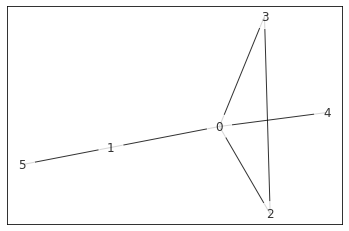

In [268]:
G = nx.Graph([(0,1),(0,2),(0,3),(0,4),(1,5),(2,3)])
edges = len(G)
A = nx.adjacency_matrix(G)
A = np.array(A.todense())
print(A)

#mc = maxcut(edges, [[0,1], [1,2], [1,3], [2,3]])
mc = maxcut(G)
mc.draw()

In [6]:
mc.build_circuit(depth = 2, beta = [0,0.3], gamma = [2,0])

In [621]:
#mc.circuit.circ.draw(output='mpl')

In [623]:
mc.solve(sims=10000)

{'0010': 1298,
 '1111': 455,
 '1101': 1310,
 '0001': 1580,
 '1100': 729,
 '1110': 1537,
 '0000': 456,
 '1010': 445,
 '0100': 29,
 '0110': 467,
 '1011': 33,
 '0011': 708,
 '0101': 436,
 '0111': 27,
 '1001': 460,
 '1000': 30}

In [277]:
#Thingy for binary thingy
s = list("{0:0eb}")
s[4] = str(edges)
binlist="".join(s)

energy = np.zeros(2**edges, dtype=int)
for k in range(0,2**edges):
    y = np.array([int(x) for x in binlist.format(k)]) #btw we gotta change this part manually when we have larger graph
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

print(energy)

[0 1 1 2 2 3 3 4 2 3 3 4 2 3 3 4 2 1 3 2 4 3 5 4 4 3 5 4 4 3 5 4 4 5 3 4 4
 5 3 4 4 5 3 4 2 3 1 2 4 3 3 2 4 3 3 2 4 3 3 2 2 1 1 0]


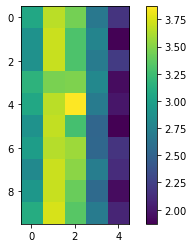

In [282]:
#Amount of samples from the grid
ngamma, nbeta = (10,5)

#Which part of the space are we gonna consider.
gmin = 0
gmax = 2*pi
bmin = 0
bmax = pi

#Maybe only consider a section of the grid
sect = 3

#Creating the grid
gamma = np.linspace(gmin, gmax/sect, ngamma)
beta = np.linspace(bmin, bmax/sect, nbeta)

#Initializing rando variables
expectation = np.zeros((ngamma,nbeta))
expectation2 = np.zeros((ngamma,nbeta))
energy = np.zeros(2**edges, dtype=int)

#Thingy for binary thingy
s = list("{0:0eb}")
s[4] = str(edges)
binlist="".join(s)


#Amount of simulations
shots = 100

#Calculating the energies that belong to each state. I think with a real quantum computer we could perhaps skip this.

for k in range(0,2**edges):
    y = np.array([int(x) for x in binlist.format(k)]) #btw we gotta change this part manually when we have larger graph
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

#Find the expectation value for each point on the grid
for i in range(0,ngamma):
    for j in range(0,nbeta):
        mc.build_circuit(depth = 2, beta = [0,beta[j]], gamma = [1,gamma[i]])
        counts = mc.solve(sims=shots)
        
        #re-ordering
        counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
        counts2 = np.array(counts).astype(int)[::-1]
        
        #Sometimes a state gets no count. This is to preserve the dimension of the energy.
        energy2 = np.zeros(len(counts2), dtype=int)
        
        #Prevent energy and counts2 array not same dimensions coz counts doesn't return no count states
        for k in range(0,len(counts2)):
            energy2[k] = energy[int(str(counts2[k,0]),2)]
        
 
        #Fancy expectation
        expectation[i,j] = np.dot(np.array(energy2),counts2[:,1])/shots        
        
        
#Fancy expectation heatmap
plt.imshow(expectation);
plt.colorbar()
plt.show()

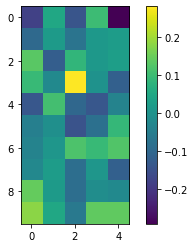

[array([[-0.18 ,  0.05 , -0.14 ,  0.1  , -0.29 ],
       [-0.095,  0.02 , -0.07 ,  0.015,  0.025],
       [ 0.135, -0.12 ,  0.085,  0.015,  0.03 ],
       [ 0.095, -0.02 ,  0.28 ,  0.   , -0.115],
       [-0.135,  0.11 , -0.1  , -0.135, -0.035],
       [-0.045, -0.005, -0.145, -0.08 ,  0.09 ],
       [-0.035,  0.01 ,  0.12 ,  0.095,  0.125],
       [-0.025,  0.025, -0.085,  0.01 , -0.115],
       [ 0.145,  0.02 , -0.085, -0.01 , -0.02 ],
       [ 0.18 ,  0.05 , -0.06 ,  0.14 ,  0.14 ]]), array([[ 0.59 ,  0.19 , -0.495, -0.64 , -0.5  ],
       [ 0.82 ,  0.21 , -0.47 , -0.715, -0.89 ],
       [ 0.82 ,  0.215, -0.5  , -0.545, -0.48 ],
       [ 0.31 ,  0.16 , -0.335, -0.77 , -0.86 ],
       [ 0.59 ,  0.4  , -0.48 , -0.94 , -0.71 ],
       [ 0.8  ,  0.195, -0.58 , -0.705, -0.66 ],
       [ 0.67 ,  0.3  , -0.555, -0.705, -0.37 ],
       [ 0.89 ,  0.35 , -0.495, -0.7  , -0.6  ],
       [ 0.77 ,  0.24 , -0.57 , -0.735, -0.62 ],
       [ 0.64 ,  0.12 , -0.525, -0.635, -0.62 ]])]
0.2900000000000

In [283]:
grad = np.gradient(expectation)
plt.imshow(grad[0]);
plt.colorbar()
plt.show()
print(grad)
print(np.amax(abs(grad[0])))
print(np.amax(abs(grad[1])))

In [433]:
G = nx.Graph([(0,1),(1,2)])
A = nx.adjacency_matrix(G)
A = np.array(A.todense())
w = -np.identity(3)+np.ones([3,3])
w[2,0] = 0
w[0,2] = 0
print(w)
x = np.array([0,1,0])
print(np.sum(np.outer(x,(1-x)) * w))
print(np.sum(np.outer(x,(1-x)) * A))
print('{0:03b}'.format(3))
print(np.array([int(x) for x in '{0:03b}'.format(2)]))

[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]
2.0
2
011
[0 1 0]
